In [39]:
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, TrainingArguments, Trainer
from datasets import Dataset, ClassLabel, Sequence, Audio
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import librosa
import matplotlib.pyplot as plt

In [40]:
data = pd.read_csv('/kaggle/input/pathset/pathset.csv')

In [ ]:
data

In [ ]:
df = data[["path", "emotion"]]

In [ ]:
df

In [ ]:
mapping = {'neutral': '0',
 'disgust': '1',
 'fear': '2',
 'sad': '3',
 'happy': '4',
 'angry': '5'}

In [ ]:
mapping

In [ ]:
df["mapping"] = df["emotion"].apply(lambda x: mapping[x])

In [ ]:
mapping.values()

In [ ]:
df

In [ ]:
file_paths = df["path"].to_list()

In [ ]:
new_dataset = Dataset.from_dict({"audio": file_paths, "label": df["mapping"].to_list()}).cast_column("audio", Audio())

In [ ]:
new_dataset = new_dataset.train_test_split(test_size=0.2)

In [ ]:
new_dataset

In [ ]:
new_dataset = new_dataset.cast_column("label", ClassLabel(names=['neutral', 'disgust', 'fear', 'sad', 'happy', 'angry']))

In [ ]:
type(new_dataset["train"]["label"][0])

In [ ]:
labels = new_dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [ ]:
id2label

In [ ]:
emotion_counts = df['emotion'].value_counts()
# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(emotion_counts.index, emotion_counts.values)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Emotions')
plt.show()

In [ ]:
new_dataset

In [ ]:
new_dataset = new_dataset.cast_column("audio", Audio(sampling_rate=16_000))

In [ ]:
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")

In [ ]:
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays, sampling_rate=feature_extractor.sampling_rate, max_length=16000*5, truncation=True, do_normalize=True
    )
    return inputs

In [ ]:
np.object = object
encoded_dataset = new_dataset.map(preprocess_function, remove_columns="audio", batched=True)

In [ ]:
!pip install evaluate
import evaluate

In [ ]:
accuracy = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
num_labels = len(id2label)
model = AutoModelForAudioClassification.from_pretrained(
    "facebook/wav2vec2-base", num_labels=num_labels, label2id=label2id, id2label=id2label
)

In [ ]:
training_args = TrainingArguments(
    output_dir="emotion_detection_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=32,
    num_train_epochs=20,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    save_total_limit=7,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

In [41]:
trainer.evaluate()

{'eval_loss': 0.6542262434959412,
 'eval_accuracy': 0.8290636042402827,
 'eval_runtime': 88.209,
 'eval_samples_per_second': 25.666,
 'eval_steps_per_second': 0.805,
 'epoch': 19.79}

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
trainer.push_to_hub()

In [42]:
results = pd.read_table("/kaggle/input/results/results_table.txt")

In [43]:
results

,Epoch,Training Loss,Validation Loss,Accuracy
0,0,1.6124,1.587263,0.398410
1,1,1.2504,1.205291,0.596290
2,2,0.8330,0.817845,0.750442
3,4,0.5791,0.639470,0.791519
4,5,0.4472,0.639761,0.796820
5,6,0.3780,0.566867,0.814488
6,8,0.2621,0.631978,0.807420
7,9,0.2310,0.634703,0.814929
8,10,0.1740,0.664902,0.809629
9,12,0.1566,0.631139,0.821113


In [51]:
x_data = results["Epoch"]
y_data = results[["Training Loss", "Validation Loss", "Accuracy"]]

In [90]:
max_accuracy = y_data['Accuracy'].max()
max_epoch = y_data.loc[y_data['Accuracy'].idxmax()].name

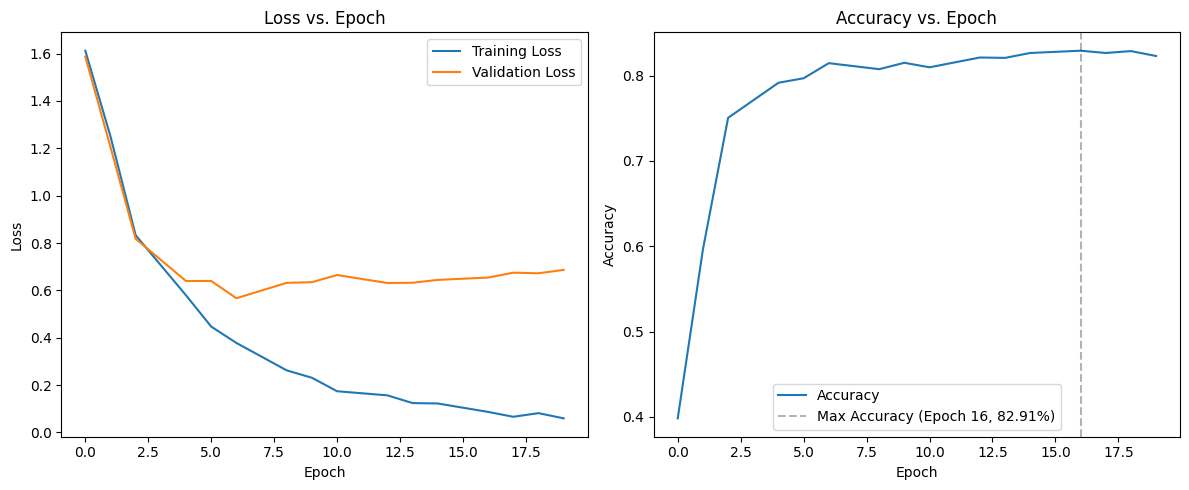

In [110]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(x_data, y_data["Training Loss"], label="Training Loss")
axs[0].plot(x_data, y_data["Validation Loss"], label="Validation Loss")
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss vs. Epoch')
axs[0].legend(loc="best")
axs[1].plot(x_data, y_data["Accuracy"], label="Accuracy")
max_accuracy = y_data['Accuracy'].max()
max_epoch = x_data.loc[y_data['Accuracy'].idxmax()]
axs[1].axvline(x=max_epoch, ymin=0.0, ymax=1.0, color='k', linestyle='--', alpha=0.3, label=f'Max Accuracy (Epoch {max_epoch}, {round(max_accuracy*100, 2)}%)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy vs. Epoch')
axs[1].legend(loc="best")
plt.tight_layout()
plt.show()